In [1]:
import pandas as pd
import json
import requests
import pprint
from functools import reduce
from keys import fred_key, eia_key

In [2]:
# EIA API Calls
production = requests.get("https://api.eia.gov/series/?api_key="+ eia_key +"&series_id=PET.WCRFPUS2.W")
imports = requests.get("http://api.eia.gov/series/?api_key="+ eia_key +"&series_id=PET.WCRIMUS2.W")
supply = requests.get("http://api.eia.gov/series/?api_key="+ eia_key +"&series_id=PET.WRPUPUS2.W")

print(production.status_code)
print(imports.status_code)
print(supply.status_code)

200
200
200


In [3]:
# FRED API Calls
# The WTI returns price for the week ending Friday. This is the same release dat as the eia data
wti = requests.get("https://api.stlouisfed.org/fred/series/observations?series_id=WCOILWTICO&frequency=wef&api_key="+ 
                   fred_key +"&file_type=json")

# These indicators are only monthly
cpi = requests.get("https://api.stlouisfed.org/fred/series/observations?series_id=CPILFESL&frequency=m&api_key="+ 
                  fred_key +"&file_type=json")
unemployment = requests.get("https://api.stlouisfed.org/fred/series/observations?series_id=UNRATE&frequency=m&api_key="+ 
                  fred_key +"&file_type=json")
personal_consumption_expenditure = requests.get("https://api.stlouisfed.org/fred/series/observations?series_id=PCE&frequency=m&api_key="+ 
                  fred_key +"&file_type=json")

print(wti.status_code)
print(cpi.status_code)
print(unemployment.status_code)
print(personal_consumption_expenditure.status_code)

200
200
200
200


In [4]:
# Convert responses to JSONs
production_json = production.json()
imports_json = imports.json()
supply_json = supply.json()
wti_json = wti.json()
cpi_json = cpi.json()
unemp_json = unemployment.json()
pce_json = personal_consumption_expenditure.json()

In [5]:
# Extract EIA Data
production_series = production_json['series'][0]
imports_series = imports_json['series'][0]
supply_series = supply_json['series'][0]

In [6]:
production_df = pd.DataFrame(production_series['data'])
imports_df = pd.DataFrame(imports_series['data'])
supply_df = pd.DataFrame(supply_series['data'])

In [7]:
# Extract FRED Data
wti_observations = wti_json['observations']
Date = []
Value = []
for observation in wti_observations:
    Date.append(observation['date'])
    Value.append(observation['value'])
wti_df = pd.DataFrame(list(zip(Date,Value)))

In [8]:
cpi_observations = cpi_json['observations']
Date = []
Value = []
for observation in cpi_observations:
    Date.append(observation['date'])
    Value.append(observation['value'])
cpi_df = pd.DataFrame(list(zip(Date,Value)))

In [30]:
unemp_observations = unemp_json['observations']
Date = []
Value = []
for observation in unemp_observations:
    Date.append(observation['date'])
    Value.append(observation['value'])
unemp_df = pd.DataFrame(list(zip(Date,Value)))
unemp_df

,0,1
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
861,2019-10-01,3.6
862,2019-11-01,3.5
863,2019-12-01,3.5
864,2020-01-01,3.6


In [31]:
pce_observations = pce_json['observations']
Date = []
Value = []
for observation in pce_observations:
    Date.append(observation['date'])
    Value.append(observation['value'])
pce_df = pd.DataFrame(list(zip(Date,Value)))
pce_df

,0,1
0,1959-01-01,306.1
1,1959-02-01,309.6
2,1959-03-01,312.7
3,1959-04-01,312.2
4,1959-05-01,316.1
...,...,...
728,2019-09-01,14707.8
729,2019-10-01,14740.6
730,2019-11-01,14786.2
731,2019-12-01,14841.0


In [35]:
# COnverting to datetime 
production_df.iloc[:,0] = pd.to_datetime(production_df.iloc[:,0],format='%Y%m%d', errors='raise')
imports_df.iloc[:,0] = pd.to_datetime(production_df.iloc[:,0],format='%Y%m%d', errors='raise')
supply_df.iloc[:,0] = pd.to_datetime(production_df.iloc[:,0],format='%Y%m%d', errors='raise')
wti_df.iloc[:,0] = pd.to_datetime(wti_df.iloc[:,0],format='%Y-%m-%d', errors='raise')
cpi_df.iloc[:,0] = pd.to_datetime(cpi_df.iloc[:,0],format='%Y-%m-%d', errors='raise')
unemp_df.iloc[:,0] = pd.to_datetime(unemp_df.iloc[:,0],format='%Y-%m-%d', errors='raise')
pce_df.iloc[:,0] = pd.to_datetime(pce_df.iloc[:,0],format='%Y-%m-%d', errors='raise')
pce_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733 entries, 0 to 732
Data columns (total 2 columns):
Date                                                  733 non-null datetime64[ns]
Personal Consumption Expenditure (billions of usd)    733 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 17.2+ KB


In [36]:
# Rename columns
production_df = production_df.rename(columns = {0:'Date', 1:'Production (thousand barrels per day)'}).sort_values(by='Date').reset_index(drop=True)
imports_df = imports_df.rename(columns = {0:'Date', 1:'Imports (thousand barrels per day)'}).sort_values(by='Date').reset_index(drop=True)
supply_df = supply_df.rename(columns = {0:'Date', 1:'Supply (thousand barrels per day)'}).sort_values(by='Date').reset_index(drop=True)
wti_df = wti_df.rename(columns = {0:'Date', 1:'Price of Barrel (usd)'}).sort_values(by='Date')
cpi_df = cpi_df.rename(columns = {0:'Date', 1:'Core CPI (index 1982-1984=100)'}).sort_values(by='Date')
unemp_df = unemp_df.rename(columns = {0:'Date', 1:'Unemployment (%)'}).sort_values(by='Date')
pce_df = pce_df.rename(columns = {0:'Date', 1:'Personal Consumption Expenditure (billions of usd)'}).sort_values(by='Date')
pce_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733 entries, 0 to 732
Data columns (total 2 columns):
Date                                                  733 non-null datetime64[ns]
Personal Consumption Expenditure (billions of usd)    733 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 17.2+ KB


In [34]:
# Merge EIA data and WTI
data_frames = [supply_df,imports_df,production_df,wti_df]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='left'), data_frames)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1531 entries, 0 to 1530
Data columns (total 5 columns):
Date                                     1531 non-null datetime64[ns]
Supply (thousand barrels per day)        1531 non-null int64
Imports (thousand barrels per day)       1531 non-null int64
Production (thousand barrels per day)    1531 non-null int64
Price of Barrel (usd)                    1531 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 71.8+ KB


In [37]:
# Merge FRED data
data_frames = [pce_df, cpi_df, unemp_df]
indicators_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='left'), data_frames)
indicators_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733 entries, 0 to 732
Data columns (total 4 columns):
Date                                                  733 non-null datetime64[ns]
Personal Consumption Expenditure (billions of usd)    733 non-null object
Core CPI (index 1982-1984=100)                        733 non-null object
Unemployment (%)                                      733 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 28.6+ KB


In [40]:
# Creating new datetime columns to merge on
indicators_merged['Merge Date']= indicators_merged['Date'].dt.strftime('%m-%Y')
indicators_merged.head(50)

,Date,Personal Consumption Expenditure (billions of usd),Core CPI (index 1982-1984=100),Unemployment (%),Merge Date
0,1959-01-01,306.1,29.9,6.0,01-1959
1,1959-02-01,309.6,29.9,5.9,02-1959
2,1959-03-01,312.7,30,5.6,03-1959
3,1959-04-01,312.2,30,5.2,04-1959
4,1959-05-01,316.1,30.1,5.1,05-1959
5,1959-06-01,318.2,30.2,5.0,06-1959
6,1959-07-01,317.8,30.2,5.1,07-1959
7,1959-08-01,320.2,30.2,5.2,08-1959
8,1959-09-01,324.2,30.3,5.5,09-1959
9,1959-10-01,322.8,30.4,5.7,10-1959


In [41]:
df_merged['Merge Date'] = df_merged['Date'].dt.strftime('%m-%Y')
df_merged.head(50)

,Date,Supply (thousand barrels per day),Imports (thousand barrels per day),Production (thousand barrels per day),Price of Barrel (usd),Merge Date
0,1990-11-16,16588,5637,6910,31.50,11-1990
1,1990-11-23,17019,5610,7440,30.69,11-1990
2,1990-11-30,15686,4532,7235,32.32,11-1990
3,1990-12-07,17753,5007,6996,27.72,12-1990
4,1990-12-14,16901,5236,7474,26.39,12-1990
5,1990-12-21,16669,5445,7245,27.56,12-1990
6,1990-12-28,17953,4468,7559,27.21,12-1990
7,1991-01-04,17319,5536,7481,26.38,01-1991
8,1991-01-11,15968,4866,7475,27.55,01-1991
9,1991-01-18,17171,5053,7461,26.85,01-1991


In [49]:
# Merging and cleaning columns
final_df = pd.merge(df_merged, indicators_merged, how='left', on='Merge Date')
final_df = final_df[['Date_x', 'Merge Date', 'Personal Consumption Expenditure (billions of usd)','Core CPI (index 1982-1984=100)',
          'Unemployment (%)', 'Supply (thousand barrels per day)', 'Imports (thousand barrels per day)', 'Production (thousand barrels per day)', 
          'Price of Barrel (usd)']]
final_df = final_df.rename(columns = {"Date_x":"Date", "Merge Date":"Month"})


,Date,Month,Personal Consumption Expenditure (billions of usd),Core CPI (index 1982-1984=100),Unemployment (%),Supply (thousand barrels per day),Imports (thousand barrels per day),Production (thousand barrels per day),Price of Barrel (usd)
0,1990-11-16,11-1990,3871.9,138.0,6.2,16588,5637,6910,31.50
1,1990-11-23,11-1990,3871.9,138.0,6.2,17019,5610,7440,30.69
2,1990-11-30,11-1990,3871.9,138.0,6.2,15686,4532,7235,32.32
3,1990-12-07,12-1990,3861.3,138.6,6.3,17753,5007,6996,27.72
4,1990-12-14,12-1990,3861.3,138.6,6.3,16901,5236,7474,26.39
...,...,...,...,...,...,...,...,...,...
1524,2020-01-31,01-2020,14870.7,266.476,3.6,20835,6615,12900,52.69
1525,2020-02-07,02-2020,NaN,NaN,NaN,20968,6978,13000,50.36
1526,2020-02-14,02-2020,NaN,NaN,NaN,19590,6547,13000,50.83
1527,2020-02-21,02-2020,NaN,NaN,NaN,19884,6217,13000,53.14


In [67]:
PriceOfBarrel = final_df["Price of Barrel (usd)"]
StaggeredList=[]
count=1
while(count<len(PriceOfBarrel)):
    StaggeredList.append(PriceOfBarrel[count])
    count +=1
StaggeredList.append(0)
final_df2 = final_df.copy()
final_df2 ["Staggered Price of Barrel"] = StaggeredList
final_df2 = final_df2.iloc[:1525]

final_df2['Personal Consumption Expenditure (billions of usd)'] = pd.to_numeric(final_df2['Personal Consumption Expenditure (billions of usd)'],errors='coerce')
final_df2['Core CPI (index 1982-1984=100)'] = pd.to_numeric(final_df2['Core CPI (index 1982-1984=100)'],errors='coerce')
final_df2['Unemployment (%)'] = pd.to_numeric(final_df2['Unemployment (%)'],errors='coerce')
final_df2['Price of Barrel (usd)'] = pd.to_numeric(final_df2['Price of Barrel (usd)'],errors='coerce')
final_df2['Staggered Price of Barrel'] = pd.to_numeric(final_df2['Staggered Price of Barrel'],errors='coerce')

final_df2.info()
    
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1525 entries, 0 to 1524
Data columns (total 10 columns):
Date                                                  1525 non-null datetime64[ns]
Month                                                 1525 non-null object
Personal Consumption Expenditure (billions of usd)    1525 non-null float64
Core CPI (index 1982-1984=100)                        1525 non-null float64
Unemployment (%)                                      1525 non-null float64
Supply (thousand barrels per day)                     1525 non-null int64
Imports (thousand barrels per day)                    1525 non-null int64
Production (thousand barrels per day)                 1525 non-null int64
Price of Barrel (usd)                                 1525 non-null float64
Staggered Price of Barrel                             1525 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 131.1+ KB


In [68]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = final_df2[["Personal Consumption Expenditure (billions of usd)",
              "Core CPI (index 1982-1984=100)",
              "Unemployment (%)",
              "Supply (thousand barrels per day)",
              "Imports (thousand barrels per day)",
              "Production (thousand barrels per day)"]]
y = final_df2["Staggered Price of Barrel"]
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.7828987651868239


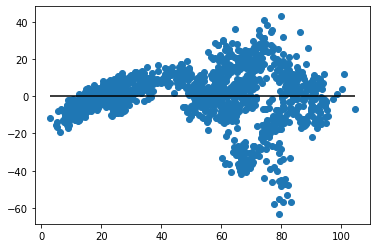

In [70]:
import matplotlib.pyplot as plt
predictions = model.predict(X)
# Plot Residuals
plt.scatter(predictions, predictions - y)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()